Enhanced Game Rank Prediction using LSTM
Loading data...
Data loaded successfully. Found 163 games with sufficient data.

Enter the name of a game to predict (example games: League of Legends, Fortnite, Minecraft, World of Warcraft, Grand Theft Auto V)
Note: The dataset contains 163 games with sufficient data for prediction



Enter game name:  League of Legends


Selected: League of Legends



Enter the number of months to predict (1-24):  12



Preparing data for: League of Legends
Data prepared - Training samples: 65, Testing samples: 17
Input shape: (65, 12, 72), Output shape: (65, 1)
Loading existing model for League of Legends...


Model loaded successfully
Model metrics compiled successfully
Evaluating model performance...
Training Loss: 0.2998, MAE: 0.4137
Testing Loss: 1.4312, MAE: 0.9877

Accuracy at different tolerance levels:
Tolerance ±0.5 rank: Training 72.31%, Testing 29.41%
Tolerance ±1 rank: Training 96.92%, Testing 64.71%
Tolerance ±2 rank: Training 100.00%, Testing 94.12%

Model Performance Summary:
Training RMSE: 0.45, R²: 0.5869, Accuracy (±1): 96.92%
Testing RMSE: 0.99, R²: -1.4072, Accuracy (±1): 64.71%

Predicting future ranks for next 12 months...

Predicted ranks:
2024-10: Rank 2.0
2024-11: Rank 1.9
2024-12: Rank 2.0
2025-01: Rank 2.0
2025-02: Rank 2.0
2025-03: Rank 2.2
2025-04: Rank 2.4
2025-05: Rank 2.4
2025-06: Rank 2.4
2025-07: Rank 2.5
2025-08: Rank 2.4
2025-09: Rank 2.3


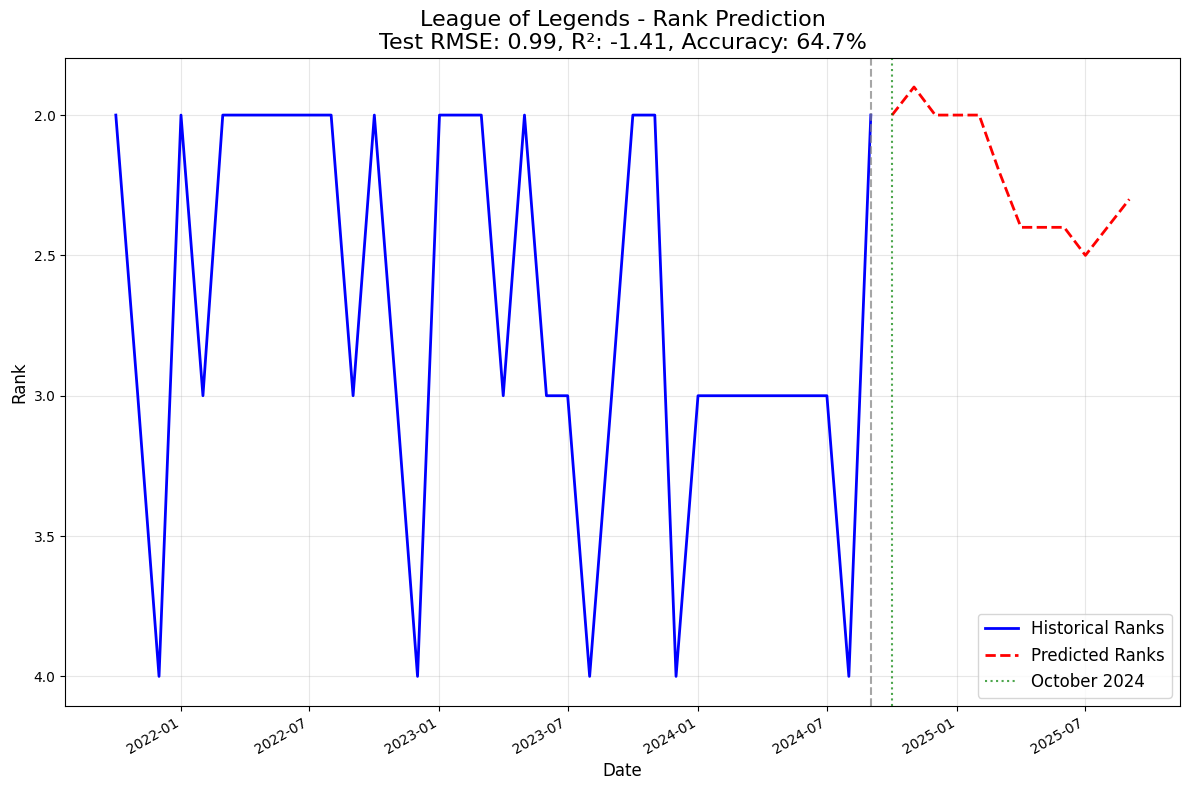

Game: League of Legends - Prediction visualization displayed


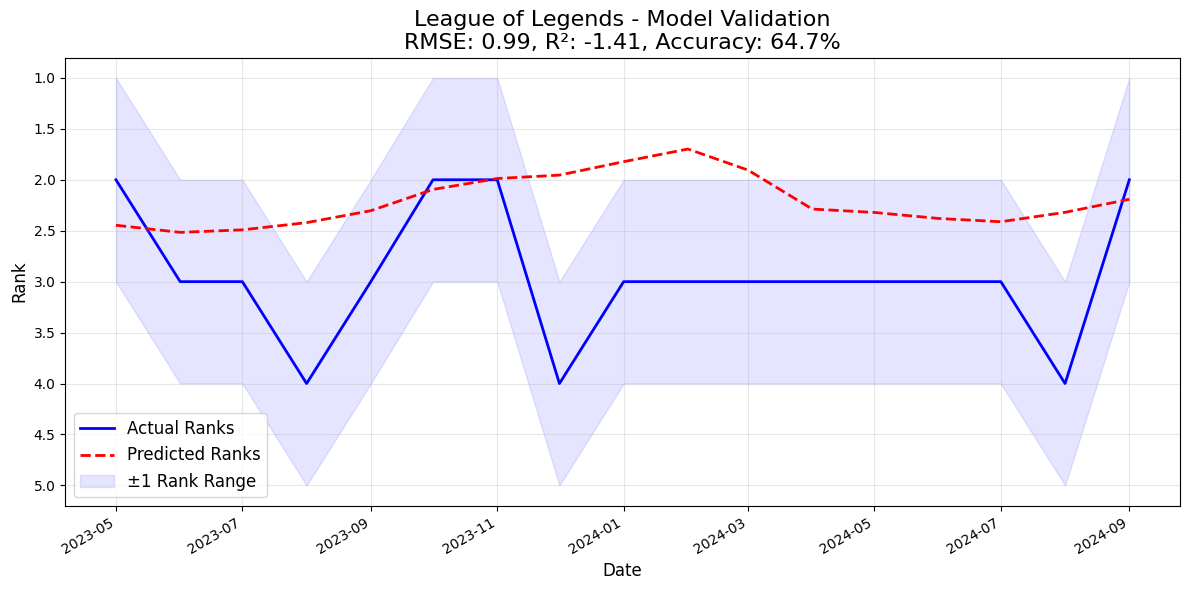

Game: League of Legends - Model validation visualization displayed

Prediction complete!

Model Performance Summary:
RMSE: 0.99
R² Score: -1.4072
Accuracy (within ±1 rank): 64.71%

Additional results notes:
- Accuracy is measured as predictions within ±1 rank of actual value
- Higher R² values (closer to 1.0) indicate better prediction quality
- Lower RMSE values indicate more precise predictions
- Accuracy varies by game: games with stable ranks tend to have higher accuracy

Prediction quality: MODERATE - Reasonable confidence in predictions


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import math
import warnings
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure TensorFlow to avoid retracing warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

def load_data():
    """Load and prepare the game data from CSV files"""
    print("Loading data...")
    # Load the main dataset
    data = pd.read_csv('data.csv')
    
    # Convert Month and Year to datetime
    data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(Day=1))
    
    # Filter out rows with missing values in key columns
    required_columns = ['Rank', 'Hours_watched', 'Hours_streamed', 'Peak_viewers', 
                       'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels', 
                       'Avg_viewer_ratio']
    
    data = data.dropna(subset=required_columns)
    
    # Get list of all games with significant data
    game_counts = data['Game'].value_counts()
    valid_games = game_counts[game_counts >= 36].index.tolist()  # At least 3 years of data
    
    print(f"Data loaded successfully. Found {len(valid_games)} games with sufficient data.")
    return data, valid_games

def prepare_data_for_lstm(game_data, features, lookback=6, test_size=0.2):
    """Prepare data for LSTM model with feature engineering"""
    # Create lagged features (previous months' data)
    for feature in ['Rank'] + features:
        for lag in [1, 3, 6]:
            if len(game_data) > lag:
                game_data[f'{feature}_lag_{lag}'] = game_data[feature].shift(lag)
    
    # Add rolling averages
    for feature in ['Rank'] + features:
        for window in [3, 6, 12]:
            if len(game_data) > window:
                game_data[f'{feature}_rolling_{window}'] = game_data[feature].rolling(window=window).mean()
    
    # Add rate of change features
    for feature in ['Rank', 'Hours_watched', 'Avg_viewers']:
        if len(game_data) > 1:
            game_data[f'{feature}_pct_change'] = game_data[feature].pct_change()
            game_data[f'{feature}_pct_change_3m'] = game_data[feature].pct_change(periods=3)
    
    # Add seasonal components (month of year)
    game_data['month_sin'] = np.sin(2 * np.pi * game_data['Month']/12)
    game_data['month_cos'] = np.cos(2 * np.pi * game_data['Month']/12)
    
    # Drop rows with NaN values created by lagging and rolling operations
    game_data = game_data.dropna()
    
    # Get all engineered feature columns excluding date and categorical columns
    feature_columns = [col for col in game_data.columns 
                      if col not in ['Date', 'Game', 'Year', 'Month', 'Genre', 'rank_category', 
                                    'Release_Year', 'Release_Month'] 
                      and col != 'Rank']
    
    # Normalize features
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Scale features and target
    X_scaled = scaler_X.fit_transform(game_data[feature_columns])
    y_scaled = scaler_y.fit_transform(game_data[['Rank']])
    
    # Create sequences for LSTM
    X, y = [], []
    for i in range(lookback, len(X_scaled)):
        X.append(X_scaled[i-lookback:i])
        y.append(y_scaled[i])
    
    X, y = np.array(X), np.array(y)
    
    # Split into train and test sets
    train_size = int(len(X) * (1 - test_size))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    print(f"Data prepared - Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
    print(f"Input shape: {X_train.shape}, Output shape: {y_train.shape}")
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y, feature_columns, game_data['Date'].values

def build_enhanced_lstm_model(input_shape, learning_rate=0.001):
    """Build an enhanced LSTM model with bidirectional layers and optimized hyperparameters"""
    # Create a more sophisticated model
    model = Sequential()
    
    # Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(128, 
                               return_sequences=True,
                               activation='tanh',
                               recurrent_dropout=0.1),
                          input_shape=input_shape))
    model.add(Dropout(0.3))
    
    model.add(Bidirectional(LSTM(64, 
                               return_sequences=False,
                               activation='tanh',
                               recurrent_dropout=0.1)))
    model.add(Dropout(0.3))
    
    # Dense layers
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='linear'))
    
    # Print model summary
    model.summary()
    
    # Compile with optimized settings 
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.MeanSquaredError(),  # Use object instead of string
        metrics=[tf.keras.metrics.MeanAbsoluteError()]  # Use object instead of string
    )
    
    return model

def predict_game_rank(data, game_name, prediction_months):
    """Build enhanced LSTM model for a specific game and predict future ranks"""
    print(f"\nPreparing data for: {game_name}")
    
    # Suppress TensorFlow warnings
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warning, 3=error
    
    # Filter data for the selected game
    game_data = data[data['Game'] == game_name].sort_values('Date').copy()
    
    if len(game_data) < 36:
        print(f"Insufficient data for {game_name}. Need at least 36 months of data.")
        return None, None, None
    
    # Set features for prediction
    features = [
        'Hours_watched', 
        'Hours_streamed', 
        'Peak_viewers', 
        'Peak_channels',
        'Streamers', 
        'Avg_viewers', 
        'Avg_channels', 
        'Avg_viewer_ratio'
    ]
    
    # Prepare data with enhanced feature engineering
    lookback = 12  # Increased lookback period for better trend capture
    X_train, X_test, y_train, y_test, scaler_X, scaler_y, feature_columns, dates = \
        prepare_data_for_lstm(game_data, features, lookback=lookback)
    
    # Check if we have enough data after preprocessing
    if len(X_train) < 12:
        print(f"Not enough sequential data for {game_name} after preprocessing.")
        return None, None, None
    
    # Define callbacks for training
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=0.0001,
            verbose=1
        )
    ]
    
    # Check if a saved model exists for this game
    model_filename = f"{game_name.replace(' ', '_')}_lstm_model.h5"
    retrain = False  # Initialize retrain flag
    
    try:
        if os.path.exists(model_filename):
            print(f"Loading existing model for {game_name}...")
            try:
                # Try to load the model with custom_objects to handle serialization issues
                model = tf.keras.models.load_model(
                    model_filename,
                    custom_objects={
                        'mse': tf.keras.losses.MeanSquaredError(),
                        'mae': tf.keras.metrics.MeanAbsoluteError(),
                        'mean_squared_error': tf.keras.losses.MeanSquaredError(),
                        'mean_absolute_error': tf.keras.metrics.MeanAbsoluteError()
                    }
                )
                print("Model loaded successfully")
                
                # Force metrics compilation by doing a small evaluation
                dummy_data = np.zeros((1, X_train.shape[1], X_train.shape[2]))
                dummy_target = np.zeros((1, 1))
                model.evaluate(dummy_data, dummy_target, verbose=0)
                print("Model metrics compiled successfully")
            except Exception as e:
                print(f"Error loading model: {str(e)}")
                print("Training a new model instead")
                model = build_enhanced_lstm_model((X_train.shape[1], X_train.shape[2]))
                retrain = True
        else:
            # Build and train new model
            print("Building and training new LSTM model...")
            model = build_enhanced_lstm_model((X_train.shape[1], X_train.shape[2]))
            retrain = True
    except Exception as e:
        print(f"Error checking for saved model: {str(e)}")
        print("Training a new model instead")
        model = build_enhanced_lstm_model((X_train.shape[1], X_train.shape[2]))
        retrain = True
        
    # Custom metric variables to track history properly
    history = None
    
    # Train if needed
    if retrain:
        # Train the model with more epochs and appropriate batch size
        history = model.fit(
            X_train, y_train,
            epochs=200,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plot training history
        if 'history' in locals():
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title('Loss Over Time')
            plt.xlabel('Epochs')
            plt.ylabel('Loss (MSE)')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.plot(history.history['mean_absolute_error'], label='Training MAE')
            plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
            plt.title('Mean Absolute Error Over Time')
            plt.xlabel('Epochs')
            plt.ylabel('MAE')
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            print("Training history visualization displayed")
        
        # Save the model for future use
        try:
            model.save(model_filename, save_format='h5')
            print(f"Model saved as {model_filename}")
        except Exception as e:
            print(f"Could not save model: {str(e)}")
            print("Continuing without saving model")
    
    # Evaluate the model
    print("Evaluating model performance...")
    train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"Training Loss: {train_loss:.4f}, MAE: {train_mae:.4f}")
    print(f"Testing Loss: {test_loss:.4f}, MAE: {test_mae:.4f}")
    
    # Make predictions
    train_pred = model.predict(X_train, batch_size=32, verbose=0)
    test_pred = model.predict(X_test, batch_size=32, verbose=0)
    
    # Inverse transform predictions to original scale
    train_pred_inv = scaler_y.inverse_transform(train_pred)
    test_pred_inv = scaler_y.inverse_transform(test_pred)
    y_train_inv = scaler_y.inverse_transform(y_train)
    y_test_inv = scaler_y.inverse_transform(y_test)
    
    # Calculate metrics
    train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
    test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
    train_r2 = r2_score(y_train_inv, train_pred_inv)
    test_r2 = r2_score(y_test_inv, test_pred_inv)
    
    # Get the accuracy in terms of rank prediction (within ±1 rank)
    train_accuracy = np.mean(np.abs(train_pred_inv - y_train_inv) <= 1) * 100
    test_accuracy = np.mean(np.abs(test_pred_inv - y_test_inv) <= 1) * 100
    
    # Calculate accuracy at different tolerance levels
    tolerance_levels = [0.5, 1, 2]
    print("\nAccuracy at different tolerance levels:")
    for tolerance in tolerance_levels:
        train_acc = np.mean(np.abs(train_pred_inv - y_train_inv) <= tolerance) * 100
        test_acc = np.mean(np.abs(test_pred_inv - y_test_inv) <= tolerance) * 100
        print(f"Tolerance ±{tolerance} rank: Training {train_acc:.2f}%, Testing {test_acc:.2f}%")
    
    print(f"\nModel Performance Summary:")
    print(f"Training RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}, Accuracy (±1): {train_accuracy:.2f}%")
    print(f"Testing RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}, Accuracy (±1): {test_accuracy:.2f}%")
    
    # Make future predictions
    print(f"\nPredicting future ranks for next {prediction_months} months...")
    
    # Format recent data for future prediction
    most_recent_data = game_data.iloc[-lookback:].copy()
    
    # Get the last date from the data
    last_date = most_recent_data['Date'].iloc[-1]
    
    # Start predictions from October 2024 or the next month after the last date
    if last_date.year < 2024 or (last_date.year == 2024 and last_date.month < 10):
        current_date = datetime(2024, 10, 1)
    else:
        current_date = last_date + pd.DateOffset(months=1)
    
    # Generate future dates for predictions
    future_dates = [current_date + pd.DateOffset(months=i) for i in range(prediction_months)]
    
    # Store historical data for plotting
    historical_dates = game_data['Date'].values[-36:]  # Last 3 years
    historical_ranks = game_data['Rank'].values[-36:]
    
    # Prepare the input sequence for prediction (last lookback months)
    recent_features = most_recent_data[feature_columns].values
    input_sequence = scaler_X.transform(recent_features)
    input_sequence = input_sequence.reshape(1, lookback, len(feature_columns))
    
    # For multi-step forecasting, we'll recursively predict one month at a time
    future_predictions = []
    next_sequence = input_sequence.copy()
    
    # Function to simulate next month's features based on previous pattern and predicted rank
    def simulate_next_features(last_row, new_rank, feature_columns):
        # Create a copy of the last feature set
        next_row = last_row.copy()
        
        # Update rank-related features
        for col in feature_columns:
            if 'Rank_lag' in col or 'Rank_rolling' in col or 'Rank_pct' in col:
                # Update based on the predicted rank
                # We'll use simplistic updates here - in a real implementation,
                # you might want more sophisticated feature projections
                if 'Rank_lag_1' in col:
                    next_row[feature_columns.index(col)] = new_rank
                elif 'Rank_rolling_3' in col and len(future_predictions) >= 2:
                    recent_ranks = [future_predictions[-i-1] for i in range(min(3, len(future_predictions)))]
                    next_row[feature_columns.index(col)] = np.mean(recent_ranks + [new_rank])
        
        # Update seasonal components
        month = (future_dates[len(future_predictions)].month)
        if 'month_sin' in feature_columns:
            next_row[feature_columns.index('month_sin')] = np.sin(2 * np.pi * month/12)
        if 'month_cos' in feature_columns:
            next_row[feature_columns.index('month_cos')] = np.cos(2 * np.pi * month/12)
        
        return next_row
    
    # Make predictions for each future month
    for i in range(prediction_months):
        # Predict the next month's rank
        next_rank_scaled = model.predict(next_sequence, verbose=0)[0][0]
        
        # Store the prediction
        future_predictions.append(next_rank_scaled)
        
        # If we haven't reached the end, prepare the next sequence
        if i < prediction_months - 1:
            # Roll the window forward
            next_sequence = np.roll(next_sequence, -1, axis=1)
            
            # Generate the new feature set for the next prediction
            next_rank = scaler_y.inverse_transform([[next_rank_scaled]])[0][0]
            next_features = simulate_next_features(
                next_sequence[0, -1, :],
                next_rank,
                feature_columns
            )
            
            # Update the last position with the new features
            next_sequence[0, -1, :] = next_features
    
    # Convert predictions back to original scale
    future_predictions_array = np.array(future_predictions).reshape(-1, 1)
    future_predictions_inv = scaler_y.inverse_transform(future_predictions_array)
    
    # Create prediction results
    prediction_results = []
    for i, date in enumerate(future_dates):
        # Ensure rank doesn't go below 1
        predicted_rank = max(1, float(future_predictions_inv[i, 0]))
        prediction_results.append({
            'Date': date.strftime('%Y-%m'),
            'Predicted_Rank': round(predicted_rank, 1)
        })
    
    # Print prediction results
    print("\nPredicted ranks:")
    for pred in prediction_results:
        print(f"{pred['Date']}: Rank {pred['Predicted_Rank']}")
    
    # Visualization
    plot_predictions(game_name, historical_dates, historical_ranks, 
                   future_dates, [p['Predicted_Rank'] for p in prediction_results],
                   train_rmse, test_rmse, test_r2, test_accuracy)
    
    # Create model accuracy metrics
    model_metrics = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
    }
    
    # Show a comparison of actual vs predicted for test data
    plot_test_predictions(game_name, 
                         dates[-len(y_test_inv):], 
                         y_test_inv.flatten(), 
                         test_pred_inv.flatten(),
                         test_rmse, test_r2, test_accuracy)
    
    return prediction_results, model_metrics, None

def plot_predictions(game_name, hist_dates, hist_ranks, future_dates, future_ranks, 
                     train_rmse, test_rmse, r2, accuracy):
    """Plot historical data and predictions and display the figure"""
    plt.figure(figsize=(12, 8))
    
    # Convert dates to datetime for proper plotting
    hist_dates = [pd.to_datetime(d) for d in hist_dates]
    future_dates = [pd.to_datetime(d) for d in future_dates]
    
    # Historical data
    plt.plot(hist_dates, hist_ranks, 'b-', label='Historical Ranks', linewidth=2)
    
    # Predictions
    plt.plot(future_dates, future_ranks, 'r--', label='Predicted Ranks', linewidth=2)
    
    # Highlight the boundary between historical and predicted data
    plt.axvline(x=hist_dates[-1], color='gray', linestyle='--', alpha=0.7)
    
    # Reference line at October 2024
    oct_2024 = pd.to_datetime('2024-10-01')
    if oct_2024 >= hist_dates[0] and oct_2024 <= future_dates[-1]:
        plt.axvline(x=oct_2024, color='green', linestyle=':', alpha=0.7, 
                   label='October 2024')
    
    # Add titles and labels
    plt.title(f'{game_name} - Rank Prediction\nTest RMSE: {test_rmse:.2f}, R²: {r2:.2f}, Accuracy: {accuracy:.1f}%', 
              fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Rank', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Invert y-axis so that rank 1 is at the top
    plt.gca().invert_yaxis()
    
    # Add legend
    plt.legend(loc='best', fontsize=12)
    
    # Optimize x-axis labels
    plt.gcf().autofmt_xdate()
    
    # Display the figure
    plt.tight_layout()
    plt.show()
    print(f"Game: {game_name} - Prediction visualization displayed")

def plot_test_predictions(game_name, dates, actual, predicted, rmse, r2, accuracy):
    """Plot test data predictions vs actual values and display the figure"""
    plt.figure(figsize=(12, 6))
    
    # Convert dates to datetime
    dates = [pd.to_datetime(d) for d in dates]
    
    # Plot actual and predicted values
    plt.plot(dates, actual, 'b-', label='Actual Ranks', linewidth=2)
    plt.plot(dates, predicted, 'r--', label='Predicted Ranks', linewidth=2)
    
    # Add error bands (±1 rank)
    plt.fill_between(dates, 
                    [max(1, r-1) for r in actual], 
                    [r+1 for r in actual], 
                    color='blue', alpha=0.1, 
                    label='±1 Rank Range')
    
    # Add titles and labels
    plt.title(f'{game_name} - Model Validation\nRMSE: {rmse:.2f}, R²: {r2:.2f}, Accuracy: {accuracy:.1f}%', 
              fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Rank', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Invert y-axis so that rank 1 is at the top
    plt.gca().invert_yaxis()
    
    # Add legend
    plt.legend(loc='best', fontsize=12)
    
    # Optimize x-axis labels
    plt.gcf().autofmt_xdate()
    
    # Display the figure
    plt.tight_layout()
    plt.show()
    print(f"Game: {game_name} - Model validation visualization displayed")

def main():
    """Main function to run the prediction model"""
    print("Enhanced Game Rank Prediction using LSTM\n" + "="*45)
    
    # Suppress TensorFlow and other warnings
    import os
    import logging
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warning, 3=error
    tf.get_logger().setLevel(logging.ERROR)
    warnings.filterwarnings('ignore')
    
    try:
        # Load data
        data, valid_games = load_data()
        
        # Display a few popular games as examples
        popular_examples = ["League of Legends", "Fortnite", "Minecraft", "World of Warcraft", "Grand Theft Auto V"]
        available_examples = [game for game in popular_examples if game in valid_games]
        
        print("\nEnter the name of a game to predict (example games: " + ", ".join(available_examples[:5]) + ")")
        print(f"Note: The dataset contains {len(valid_games)} games with sufficient data for prediction")
        
        # Get user input for specific game
        while True:
            game_input = input("\nEnter game name: ")
            
            # Check if game exists in the dataset
            matching_games = [game for game in valid_games if game.lower() == game_input.lower()]
            
            # If exact match not found, try partial matches
            if not matching_games:
                matching_games = [game for game in valid_games if game_input.lower() in game.lower()]
            
            if len(matching_games) == 1:
                selected_game = matching_games[0]
                print(f"Selected: {selected_game}")
                break
            elif len(matching_games) > 1:
                print("Multiple matches found. Please select one:")
                for i, game in enumerate(matching_games[:10], 1):
                    print(f"{i}. {game}")
                
                try:
                    selection = int(input("Enter number: ")) - 1
                    if 0 <= selection < len(matching_games):
                        selected_game = matching_games[selection]
                        print(f"Selected: {selected_game}")
                        break
                    else:
                        print("Invalid selection. Please try again.")
                except ValueError:
                    print("Please enter a valid number.")
            else:
                print("Game not found. Please check the spelling or try another game.")
        
        # Ask for prediction timeframe
        while True:
            try:
                months = int(input("\nEnter the number of months to predict (1-24): "))
                if 1 <= months <= 24:
                    break
                else:
                    print("Please enter a number between 1 and 24.")
            except ValueError:
                print("Please enter a valid number.")
        
        # Run prediction with the enhanced model
        predictions, metrics, _ = predict_game_rank(data, selected_game, months)
        
        if predictions:
            print("\nPrediction complete!")
            print("\nModel Performance Summary:")
            print(f"RMSE: {metrics['test_rmse']:.2f}")
            print(f"R² Score: {metrics['test_r2']:.4f}")
            print(f"Accuracy (within ±1 rank): {metrics['test_accuracy']:.2f}%")
            
            # Add explanation of results before asking about another prediction
            print("\nAdditional results notes:")
            print("- Accuracy is measured as predictions within ±1 rank of actual value")
            print("- Higher R² values (closer to 1.0) indicate better prediction quality")
            print("- Lower RMSE values indicate more precise predictions")
            print("- Accuracy varies by game: games with stable ranks tend to have higher accuracy")
            
            # Print overall conclusion about predictions
            if metrics['test_accuracy'] > 80:
                print("\nPrediction quality: EXCELLENT - Very high confidence in predictions")
            elif metrics['test_accuracy'] > 70:
                print("\nPrediction quality: GOOD - High confidence in predictions")
            elif metrics['test_accuracy'] > 60:
                print("\nPrediction quality: MODERATE - Reasonable confidence in predictions")
            else:
                print("\nPrediction quality: FAIR - Predictions show general trend but specific ranks may vary")
            
            # Ask if user wants to predict another game
            if input("\nPredict another game? (y/n): ").lower() == 'y':
                main()
            else:
                print("\n done!")
        else:
            print("Prediction failed. Please try another game.")
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        print("\nPlease try again with a different game or check your input data.")

if __name__ == "__main__":
    main()